<a href="https://colab.research.google.com/github/Saim-Hassan786/LangGraph_02/blob/main/LangGraph_Features_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Code

In [ ]:
!pip install --quiet -U langgraph
!pip install --quiet -U langchain
!pip install --quiet -U langchain-google-genai

from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash-exp",
    api_key = GOOGLE_API_KEY,
    temperature = 0
)

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, RemoveMessage
from langgraph.graph import START, END , StateGraph , MessagesState
from langgraph.graph.state import CompiledStateGraph
from IPython.display import display, Markdown, Image
from langchain_core.tools import tool
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver

# Starter CODE

In [ ]:
class State(MessagesState):
  summary : str


def node_call_llm(state:State, config:RunnableConfig)->State:
  summary = state.get("summary","")
  if summary:
    summary = f"Summary of the Earlier Conversation: {summary}"
    messages = [SystemMessage(content=summary)]+state["messages"]
  else:
    messages = state["messages"]
  response = llm.invoke(messages,config)
  return {"messages":response}


def summarization(state:State)->State:
  summary = state.get("summary","")
  if summary:
    SystemMessage = f"This is the Summary of the Earlier Conversation : {summary}, extend this summary by taking into account the messages above"
  else:
    SystemMessage = f"Create a summary of the conversational messages above"
  messages = state["messages"]+ [HumanMessage(content=SystemMessage)]
  response = llm.invoke(messages)
  delete_msg = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
  return {"summary":response.content, "messages": delete_msg}


def should_continue(state:State)->State:
  messages = state["messages"]
  if len(messages) > 6 :
    return "summarization"
  else:
    return END

# Memory SETUP

In [ ]:
%%capture --no-stderr
%pip install -U langgraph-checkpoint-postgres psycopg psycopg-pool

In [ ]:
from google.colab import userdata
DB_URI_1 = userdata.get('DB_URI_1')


from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver


connection_kwargs = {"autocommit":True,"prepare_threshold":0}
pool = ConnectionPool(conninfo=DB_URI_1,max_size=20,kwargs=connection_kwargs)
checkpointer = PostgresSaver(pool)
checkpointer.setup()

# Graph STRUCTURE

In [ ]:
builder : StateGraph = StateGraph(state_schema=State)

builder.add_node("node_call_llm",node_call_llm)
builder.add_node("summarization",summarization)

builder.add_edge(START,"node_call_llm")
builder.add_conditional_edges("node_call_llm",should_continue)
builder.add_edge("summarization",END)

graph : CompiledStateGraph = builder.compile(checkpointer=checkpointer)

# TEST CODE

In [ ]:
config = {"configurable":{"thread_id":"1"}}
input = HumanMessage(content="Hi I am SHA")
output = graph.invoke({"messages":[input]},config)
import pprint
for m in output["messages"][-1:]:
  m.pretty_print()

input_message = HumanMessage(content="I am Agentic AI Engineer?")
output = graph.invoke({"messages": [input_message]},config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="My Favourite Sports is Cricket!")
output = graph.invoke({"messages": [input_message]},config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi SHA, it's nice to meet you! How can I help you today? Are you looking for information, want to chat, or have a specific task in mind? Let me know!
================================== Ai Message ==================================

Okay, SHA, that's a fascinating and cutting-edge role! "Agentic AI Engineer" implies you're working at the forefront of AI development, likely focusing on creating and managing AI systems that can act autonomously and intelligently. 

Here's what I understand about what an Agentic AI Engineer might do, and please correct me if I'm off the mark:

**Key Responsibilities and Areas of Focus:**

* **Developing Autonomous Agents:** You're likely involved in designing, building, and training AI agents that can perceive their environment, make decisions, and take actions to achieve specific goals without constant human intervention.
* **Reinforcement Learning Expertise:** Reinforcement

In [ ]:
config = {"configurable":{"thread_id":"1"}}
input = [HumanMessage(content="what is my name, what I like and what I do")]
output = graph.invoke({"messages":input},config)
for m in output["messages"][-1:]:
  m.pretty_print()

================================== Ai Message ==================================

Your name is SHA, you like Cricket, and you are an Agentic AI Engineer.


# MODULE 3.0


# Streaming Interruptions

In [ ]:
config = {"configurable":{"thread_id":"2"}}
for chunks in graph.stream({"messages":[HumanMessage(content="Hi there ! How are you")]},config,stream_mode="updates"):
  print(chunks)

{'node_call_llm': {'messages': AIMessage(content="Hi! I'm doing well, thank you for asking! As a large language model, I don't experience feelings in the same way humans do, but I'm functioning optimally and ready to assist you. \n\nHow are you doing today? Is there anything I can help you with?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-2c615e94-f183-413f-b1e1-8b2df2985aa9-0', usage_metadata={'input_tokens': 7, 'output_tokens': 62, 'total_tokens': 69, 'input_token_details': {'cache_read': 0}})}}


In [ ]:
config = {"configurable":{"thread_id":"1"}}
for chunks in graph.stream({"messages":[HumanMessage(content="Tell me about my self")]},config,stream_mode="updates"):
  print(chunks)

{'node_call_llm': {'messages': AIMessage(content='Okay, let\'s delve a bit deeper into what we know about you, SHA, and what we can infer based on that information. I\'ll try to paint a more complete picture of "you" based on our conversation:\n\n**Based on Direct Information:**\n\n*   **Name:** You are known as **SHA**. This is your identifier in our interaction.\n*   **Profession:** You are an **Agentic AI Engineer**. This suggests you are involved in the development of autonomous AI systems. This likely means you have a strong background in:\n    *   **Artificial Intelligence:** You understand the principles of AI, machine learning, and deep learning.\n    *   **Software Engineering:** You are proficient in programming and software development practices.\n    *   **Robotics/Automation:** You likely have knowledge of how to build and control autonomous systems.\n    *   **Problem Solving:** You are adept at breaking down complex problems and designing AI solutions.\n*   **Interest:**

In [ ]:
config = {"configurable":{"thread_id":"1"}}
for chunks in graph.stream({"messages":[HumanMessage(content="Tell me about Nvidia In 15 words")]},config,stream_mode="updates"):
  print(chunks)

{'node_call_llm': {'messages': AIMessage(content='Nvidia is a tech company known for its GPUs, driving advancements in AI and graphics.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-382a6d35-9362-4646-9785-2cec7c9d4797-0', usage_metadata={'input_tokens': 723, 'output_tokens': 18, 'total_tokens': 741, 'input_token_details': {'cache_read': 0}})}}
{'summarization': {'summary': 'Okay, here\'s an extended summary of our conversation, incorporating the previous summary and the additional messages about Nvidia:\n\n*

In [ ]:
config = {"configurable":{"thread_id":"1"}}
for chunks in graph.stream({"messages":[HumanMessage(content="Tell me about OpenAI In 15 words")]},config,stream_mode="updates"):
  print(chunks)

{'node_call_llm': {'messages': AIMessage(content="Okay, I understand you want a concise description. Here's another attempt at describing OpenAI in 15 words:\n\nOpenAI: AI research company, creating powerful models like GPT, pushing the boundaries of AI.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-5a8ae4f9-f7fd-4db6-a410-70ccdc99a021-0', usage_metadata={'input_tokens': 903, 'output_tokens': 46, 'total_tokens': 949, 'input_token_details': {'cache_read': 0}})}}
{'summarization': {'summary': 'Okay, here\'s the

In [ ]:
config = {"configurable":{"thread_id":"1"}}
for chunks in graph.stream({"messages":[HumanMessage(content="Tell me about Gemini In 15 words")]},config,stream_mode="updates"):
  print(chunks)

{'node_call_llm': {'messages': AIMessage(content="Okay, here's another 15-word description of Gemini:\n\nGemini: Google's powerful AI, capable of understanding text, images, audio, and code for various tasks.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-367765d6-ff31-40a1-9608-f0bd36740224-0', usage_metadata={'input_tokens': 1301, 'output_tokens': 40, 'total_tokens': 1341, 'input_token_details': {'cache_read': 0}})}}


In [ ]:
config = {"configurable":{"thread_id":"1"}}
for chunks in graph.stream({"messages":[HumanMessage(content="Tell me about Claude In 10 words")]},config,stream_mode="updates"):
  print(chunks)

{'node_call_llm': {'messages': AIMessage(content="Okay, here's a 10-word description of Claude:\n\nClaude is Anthropic's AI assistant, known for its helpful and harmless nature.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-d00b3c0f-a012-42e0-a550-6a90310c6404-0', usage_metadata={'input_tokens': 1352, 'output_tokens': 34, 'total_tokens': 1386, 'input_token_details': {'cache_read': 0}})}}


In [ ]:
config = {"configurable":{"thread_id":"1"}}
for chunks in graph.stream({"messages":[HumanMessage(content="Tell me about Anthropic In 10 words")]},config,stream_mode="updates"):
  chunks["node_call_llm"]["messages"].pretty_print()

================================== Ai Message ==================================

Okay, here's another 10-word description of Anthropic:

Anthropic: Develops helpful, harmless AI, prioritizing safety and ethical considerations.


In [ ]:
config = {"configurable":{"thread_id":"1"}}
for chunks in graph.stream({"messages":[HumanMessage(content="Tell me about Groq In 10 words")]},config,stream_mode="updates"):
  chunks["node_call_llm"]["messages"].pretty_print()

================================== Ai Message ==================================

Okay, here's a 10-word description of Groq:

Groq: Develops ultra-fast AI inference processors, focusing on speed and performance.


In [ ]:
config = {"configurable":{"thread_id":"3"}}
input_msg = [HumanMessage(content="Hi I am SHA")]
for chunks in graph.stream({"messages":input_msg},config,stream_mode="values"):
  for m in chunks["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi I am SHA
================================ Human Message =================================

Hi I am SHA
================================== Ai Message ==================================

Hi SHA, it's nice to meet you! How can I help you today? Are you looking for information, want to chat, or have a specific task in mind? Let me know!


In [ ]:
config = {"configurable":{"thread_id":"4"}}
input_msg = [HumanMessage(content="Do you know my name")]
for chunks in graph.stream({"messages":input_msg},config,stream_mode="values"):
  for m in chunks["messages"]:
    m.pretty_print()

================================ Human Message =================================

Do you know my name
================================ Human Message =================================

Do you know my name
================================== Ai Message ==================================

As a large language model, I don't have access to personal information about you, including your name. I don't have memory of past conversations or any way to identify you personally. 

So, no, I don't know your name. You'll have to tell me if you'd like me to know it! 😊


In [ ]:
config = {"configurable":{"thread_id":"3"}}
input_msg = [HumanMessage(content="Can you me tell me my name that I introduced myself with you earlier")]
for chunks in graph.stream({"messages":input_msg},config,stream_mode="values"):
  for m in chunks["messages"]:
    m.pretty_print()

================================ Human Message =================================

Can you me tell me my name that I introduced myself with you earlier
================================== Ai Message ==================================

Yes, you introduced yourself as **SHA** earlier.
================================ Human Message =================================

Can you me tell me my name that I introduced myself with you earlier
================================== Ai Message ==================================

You introduced yourself as **SHA** earlier.
================================ Human Message =================================

Can you me tell me my name that I introduced myself with you earlier
================================ Human Message =================================

Can you me tell me my name that I introduced myself with you earlier
================================== Ai Message ==================================

Yes, you introduced yourself as **SHA** earlier.
========

# Modified Checkpointer For Using @stream method

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()
graph1: CompiledStateGraph = builder.compile(checkpointer=memory)

In [ ]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the Manchester United team")
async for event in graph1.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_stream. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: node_call_llm. Type: on_chain_start. Name: node_call_llm
Node: node_call_llm. Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: node_call_llm. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: node_call_llm. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: node_call_llm. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: node_call_llm. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: node_call_llm. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: node_call_llm. Type: on_chat_model_stream. Name: C

In [ ]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the Manchester United team")
async for event in graph1.astream_events({"messages": [input_message]}, config, version="v2"):
  if event["event"] == "on_chat_model_stream" and event["metadata"].get("langgraph_node") == "node_call_llm":
    print(event["data"])

{'chunk': AIMessageChunk(content='Okay', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run-dcfffb1c-7f50-440a-a4b5-94d6f8b80cff', usage_metadata={'input_tokens': 1011, 'output_tokens': 0, 'total_tokens': 1011, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=", let's talk about the Manchester United team! It's a club", additional_kwargs={}, response_metadata={'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-dcfffb1c-7f50-440a-a4b5-94d6f8b80cff', usage_metadata={'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(conten

In [ ]:
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the Barcelona team")
async for event in graph1.astream_events({"messages":[input_message]},config,version="v2"):
  if event["event"]=="on_chat_model_stream" and event["metadata"].get("langgraph_node","") == "node_call_llm":
    data = event["data"]
    print(data["chunk"].content,end="!")

Okay!, let's dive into the world of FC Barcelona! Here's a! breakdown of the team, covering various aspects:

**General Overview:**

*! **Name:** Futbol Club Barcelona (often shortened to FC Barcelona or Barça)
* **Based In:** Barcelona, Catalonia, Spain
* **Nickname:**! Blaugrana (referring to their blue and garnet colors)
* **Founded:** 1899
* **Stadium:** Spotify Camp Nou (!currently undergoing renovations, they are playing at the Estadi Olímpic Lluís Companys)
* **Rivals:** Real Madrid (El Clásico), Espanyol (Derbi Barceloní)
* **Style of Play:**! Historically known for their possession-based, attacking style of play, often referred to as "tiki-taka." While they've evolved, the emphasis on ball control and intricate passing remains a core principle.

**Current Squad (!as of October 26, 2023 - subject to change):**

It's important to note that squads change frequently due to transfers and injuries. Here's a general overview of key players:

* **Goalkeepers:**
    * Marc-André ter St

# LangChain STUDIO

In [ ]:
!pip install langgraph-sdk
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "https://ac80-103-151-43-15.ngrok-free.app"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [ ]:
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'created_at': '2025-01-07T07:27:15.645637+00:00',
  'updated_at': '2025-01-07T07:27:15.645637+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'dynamic_breakpoints'},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'created_at': '2024-12-02T09:25:45.833162+00:00',
  'updated_at': '2024-12-02T09:25:45.833162+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'agent'}]

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="agent",
                                      input={"messages": [input_message]},
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '1efcdb27-f596-679b-a1a0-79f4c4cd8f0a', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '6135e07c-58df-4a92-b52d-98459e5251b5', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '6135e07c-58df-4a92-b52d-98459e5251b5', 'example': False}, {'content': '', 'additional_kwargs': {'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, 'type': 'ai', 'name': None, 'id': 'run-feb5f6f7-8fb2-43c7-b53f-9654ec54

In [ ]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'example': False} response_metadata={} id='2599173f-1b35-47c8-94e8-6e09a9622d93'
content='' additional_kwargs={'additional_kwargs': {'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 168, 'output_tokens': 3, 'total_tokens': 171, 'input_token_details': {'cache_read': 0}}} response_metadata={} id='run-9a9a6ae9-fd8b-4b3e-9b6b-2e6594421de9-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': 'd90cd9bd-9969-4a34-a06e-27933d709e02', 'type': 'tool_call'}]
content='6' name='multiply' id='664c530b-2765-4985-9569-c59a93ac217b' tool_call_id='d90cd9bd-9969-4a34-a06e-27933d709e02'
conten

# Another Example Of LangChain Studio API

In [ ]:
!pip install langgraph-sdk
from langgraph_sdk import get_client

url = "https://ac80-103-151-43-15.ngrok-free.app"
client = get_client(url=url)

In [ ]:
assistants = await client.assistants.search()

In [ ]:
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'created_at': '2025-01-07T07:27:15.645637+00:00',
  'updated_at': '2025-01-07T07:27:15.645637+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'dynamic_breakpoints'},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'created_at': '2024-12-02T09:25:45.833162+00:00',
  'updated_at': '2024-12-02T09:25:45.833162+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'agent'}]

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 5 and 5")

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = {"messages":[input_message]},
    stream_mode = "values"

):
   print(event)

StreamPart(event='metadata', data={'run_id': '1efcdb29-db71-6764-9e0f-2b340b7991cb', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 5 and 5', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3f781ee7-5050-458c-b268-be15dba76e8b', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 5 and 5', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3f781ee7-5050-458c-b268-be15dba76e8b', 'example': False}, {'content': '', 'additional_kwargs': {'function_call': {'name': 'multiply', 'arguments': '{"a": 5.0, "b": 5.0}'}}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, 'type': 'ai', 'name': None, 'id': 'run-6f60ddc5-d1fc-4a5c-878c-5f8002b8

# Just a Format To View Data More Clearly

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):

    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)

    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print("-" * 50)

Metadata: Run ID - 1efcdac0-d0b2-6274-af75-f7844ea29e70
--------------------------------------------------
Tool Calls:
Tool Call ID: 20fcfc92-b933-4dc0-987a-50eb10c0f7bb, Function: multiply, Arguments: {'a': 2.0, 'b': 3.0}
Response Metadata: Finish Reason - N/A
--------------------------------------------------
Tool Calls:
Tool Call ID: 20fcfc92-b933-4dc0-987a-50eb10c0f7bb, Function: multiply, Arguments: {'a': 2.0, 'b': 3.0}
Response Metadata: Finish Reason - STOP
--------------------------------------------------
AI: The
Response Metadata: Finish Reason - N/A
--------------------------------------------------
AI: The result is 6.
Response Metadata: Finish Reason - STOP
--------------------------------------------------


# Next Topic BreakPoints (Human In The Loop)

In [ ]:
def multiply(a:int,b:int)->int:
  """
  Multiply a and b
  Args:
    a: int
    b: int
  Returns:
    a * b
  """
  return a*b

def add(a:int,b:int)->int:
  """
  Add a and b
  Args:
    a: int
    b: int
  Returns:
    a + b
  """
  return a+b

def divide(a:int,b:int)->int:
  """
  Divide a and b
  Args:
    a: int
    b: int
  Returns:
    a / b
  """
  return a/b

tools : list[tool] = [add,multiply,divide]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs")

def assistant(state:MessagesState):
  return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

builder_1 :StateGraph = StateGraph(state_schema=MessagesState)

builder_1.add_node("assistant",assistant)
builder_1.add_node("tools",ToolNode(tools))

builder_1.add_edge(START,"assistant")
builder_1.add_conditional_edges("assistant",tools_condition)
builder_1.add_edge("tools","assistant")

memory : MemorySaver = MemorySaver()
graph_111 : CompiledStateGraph = builder_1.compile(interrupt_before=["tools"],checkpointer=memory)

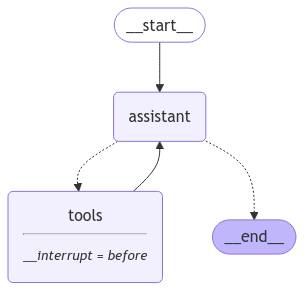

In [ ]:
display(Image(graph_111.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
input_message = [HumanMessage(content="Multiply 2 and 3")]
config_1 = {"configurable":{"thread_id":"1"}}
for event in graph_111.stream({"messages":input_message},config_1,stream_mode="values"):
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (b6f7ffe9-13eb-4a73-aba2-81a4c69bfb26)
 Call ID: b6f7ffe9-13eb-4a73-aba2-81a4c69bfb26
  Args:
    a: 2.0
    b: 3.0


# To Check The Upcoming State To Execute

In [ ]:
state = graph_111.get_state(config_1)
state.next

('tools',)

# To Check The History Of All The States SnapShot

In [ ]:
state_1= graph_111.get_state_history(config_1)
state_1

<generator object Pregel.get_state_history at 0x7a973997f290>

# To Resume the Paused Graph Again

In [ ]:
for event in graph_111.stream(None,config_1,stream_mode="values"):
  event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (b6f7ffe9-13eb-4a73-aba2-81a4c69bfb26)
 Call ID: b6f7ffe9-13eb-4a73-aba2-81a4c69bfb26
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2 * 3 = 6


# Example With User Approval

In [ ]:
input_message_1 = [HumanMessage(content="Multily 5 by 5")]
config_2 = {"configurable":{"thread_id":"2"}}
for event in graph_111.stream({"messages":input_message_1},config_2,stream_mode="values"):
  event["messages"][-1].pretty_print()

user_approval = input("Do you want to proceed with this Operation  yes/no")

if user_approval.lower() == "yes":
  for event in graph_111.stream(None,config_2,stream_mode="values"):
    event["messages"][-1].pretty_print()

else :
  print("Operation Cancelled By User")

================================ Human Message =================================

Multily 5 by 5
================================== Ai Message ==================================
Tool Calls:
  multiply (a8e183cd-de93-49fe-abdf-dd957d0af6a5)
 Call ID: a8e183cd-de93-49fe-abdf-dd957d0af6a5
  Args:
    a: 5.0
    b: 5.0
Do you want to proceed with this Operation  yes/noyes
================================== Ai Message ==================================
Tool Calls:
  multiply (a8e183cd-de93-49fe-abdf-dd957d0af6a5)
 Call ID: a8e183cd-de93-49fe-abdf-dd957d0af6a5
  Args:
    a: 5.0
    b: 5.0
================================= Tool Message =================================
Name: multiply

25
================================== Ai Message ==================================

25


In [ ]:
input_message_2 = [HumanMessage(content="Divide 50 by 5")]
config_3 = {"configurable":{"thread_id":"3"}}
for event in graph_111.stream({"messages":input_message_2},config_3,stream_mode="values"):
  event["messages"][-1].pretty_print()

user_approval = input("Do you want to proceed with this Operation  yes/no ")

if user_approval.lower() == "yes":
  for event in graph_111.stream(None,config_3,stream_mode="values"):
    event["messages"][-1].pretty_print()

else :
  print("Operation Cancelled By User")

================================ Human Message =================================

Divide 50 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (b634c729-ec53-4491-9781-941a21c70b58)
 Call ID: b634c729-ec53-4491-9781-941a21c70b58
  Args:
    a: 50.0
    b: 5.0
Do you want to proceed with this Operation  yes/noyes
================================== Ai Message ==================================
Tool Calls:
  divide (b634c729-ec53-4491-9781-941a21c70b58)
 Call ID: b634c729-ec53-4491-9781-941a21c70b58
  Args:
    a: 50.0
    b: 5.0
================================= Tool Message =================================
Name: divide

10.0
================================== Ai Message ==================================

50 divided by 5 is 10.


In [ ]:
input_message_3 = [HumanMessage(content="Add 50 by 50")]
config_4 = {"configurable":{"thread_id":"4"}}
for event in graph_111.stream({"messages":input_message_3},config_4,stream_mode="values"):
  event["messages"][-1].pretty_print()

user_approval = input("Do you want to proceed with this Operation  yes/no")

if user_approval.lower() == "yes":
  for event in graph_111.stream(None,config_4stream_mode="values"):
    event["messages"][-1].pretty_print()

else :
  print("Operation Cancelled By User")

================================ Human Message =================================

Add 50 by 50
================================== Ai Message ==================================
Tool Calls:
  add (6a73f326-1abb-4984-9477-0db703dfa3eb)
 Call ID: 6a73f326-1abb-4984-9477-0db703dfa3eb
  Args:
    a: 50.0
    b: 50.0
Do you want to proceed with this Operation  yes/nono
Operation Cancelled By User


# Example of Interruption With Langgraph API

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '4ebad228-7f2d-4e1a-be9a-58bce71a7c58', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, 'type': 'ai', 'name': None, 'id': 'run-d0add50c-e3a7-4f44-b679-0e341c4c5007-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '2114b6e2-140b-41d6-a0c2-0af7acc6beb3', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_toke

# To Resume

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, 'type': 'ai', 'name': None, 'id': 'run-d0add50c-e3a7-4f44-b679-0e341c4c5007-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': '2114b6e2-140b-41d6-a0c2-0af7acc6beb3', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 168, 'output_tokens': 3, 'total_tokens': 171, 'input_token_details': {'cache_read': 0}}}
--------------------------------------------------
Receiving new event of type: values...
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '2041cb9a-66ec-4fa5-a6a6-9a86ca4bde94', 

# Edit the BreakPoints Or Interruptions

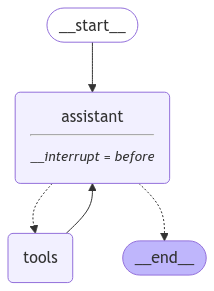

In [ ]:
graph_222 = builder_1.compile(interrupt_before=["assistant"],checkpointer=memory)
display(Image(graph_222.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
initial_input_333 =  [HumanMessage(content="Multiply 2 and 3")]
thread = {"configurable":{"thread_id":"5"}}

for event in graph_222.stream({"messages":initial_input_333},thread,stream_mode="values"):
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [ ]:
state = graph_222.get_state(thread)
state.next

('assistant',)

# Now to Update Or Edit State

In [ ]:
graph_222.update_state(
    thread,
    {"messages":[HumanMessage(content="No,Multiply 10 by 10")]}
)

{'configurable': {'thread_id': '5',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcdc3b-4597-6818-8001-9e5e262e8f00'}}

In [ ]:
new_state = graph_222.get_state(thread).values
for m in new_state["messages"]:
  m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No,Multiply 10 by 10


# Now To Resume

In [ ]:
for event in graph_222.stream(None,thread,stream_mode="values"):
  event["messages"][-1].pretty_print()

================================ Human Message =================================

No,Multiply 10 by 10
================================== Ai Message ==================================
Tool Calls:
  multiply (23012618-9925-4dde-9c44-0513317da1c6)
 Call ID: 23012618-9925-4dde-9c44-0513317da1c6
  Args:
    a: 10.0
    b: 10.0
================================= Tool Message =================================
Name: multiply

100


In [ ]:
for event in graph_222.stream(None,thread,stream_mode="values"):
  event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

100
================================== Ai Message ==================================

10 multiplied by 10 is 100.


# Editing Graph State With LangGraph API

In [ ]:
initial_input = {"messages": "Multiply 50 and 3"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 50 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '56e78332-d3f9-44f8-adb3-7790586a90c5', 'example': False}
--------------------------------------------------


In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 50 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '56e78332-d3f9-44f8-adb3-7790586a90c5',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '821b8011-2a59-a83e-7ddc-f98ec4f3cc9d',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'step': 0,
  'run_id': '1efcdc63-cc8e-6906-a230-076c76dd976a',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': '9bf17d03-e082-43eb-be1d-ec278d19ae57',
  'created_by': 'system',
  'run_attempt': 1,
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'langgraph_host': 'self-hosted',
  'langgraph_plan': 'developer',
  'x-forwarded-for': '34.55.98.47',
  'x-forwarded-host': 'ac80-103-151-43-15.ngrok-free.app',
  'langgraph_version': '0.

In [ ]:
last_msg = current_state["values"]['messages'][-1]
last_msg

{'content': 'Multiply 50 and 3',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '56e78332-d3f9-44f8-adb3-7790586a90c5',
 'example': False}

# Edit The State Here

In [ ]:
last_msg["content"] = "No, Multiply 100 by 5"
last_msg

{'content': 'No, Multiply 100 by 5',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '56e78332-d3f9-44f8-adb3-7790586a90c5',
 'example': False}

In [ ]:
await client.threads.update_state(thread['thread_id'], {"messages": last_msg})

{'checkpoint': {'thread_id': '9bf17d03-e082-43eb-be1d-ec278d19ae57',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcdca7-5bce-6243-8001-6dd253749564'},
 'configurable': {'thread_id': '9bf17d03-e082-43eb-be1d-ec278d19ae57',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcdca7-5bce-6243-8001-6dd253749564'},
 'checkpoint_id': '1efcdca7-5bce-6243-8001-6dd253749564'}

# Now To Resume Graph

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, Multiply 100 by 5', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '56e78332-d3f9-44f8-adb3-7790586a90c5', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'function_call': {'name': 'multiply', 'arguments': '{"a": 100.0, "b": 5.0}'}}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, 'type': 'ai', 'name': None, 'id': 'run-8bc05d10-24b2-4519-8b78-a92e872d3099-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 100.0, 'b': 5.0}, 'id': 'a01dbe43-6375-48b6-be97-94fdf2264f02', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'i

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '500', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '87830ca1-fb04-4081-8e03-979878bb8fc0', 'tool_call_id': 'a01dbe43-6375-48b6-be97-94fdf2264f02', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of multiplying 100 by 5 is 500.', 'additional_kwargs': {}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, 'type': 'ai', 'name': None, 'id': 'run-47293c3d-e268-4309-ab94-968bf446b506-0', 'example': False, 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 209, 'output_tokens': 18, 'total_tokens': 227, 'input_token_details': {'cache_read': 0}}}
--------------------------------------------------


# Now With A Human FeedBack

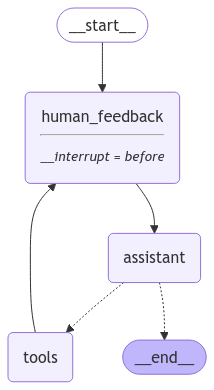

In [ ]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def human_feedback(state: MessagesState):
    pass

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder: StateGraph = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph_234 = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph_234.get_graph().draw_mermaid_png()))

In [ ]:
initial_input = {"messages": "Multiply 2 and 3"}

thread = {"configurable": {"thread_id": "5"}}

for event in graph_234.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

user_input = input("Tell me how you want to update the state: ")

graph_234.update_state(thread, {"messages": user_input}, as_node="human_feedback")

for event in graph_234.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
Tell me how you want to update the state: Multiply 5 by 5
================================ Human Message =================================

Multiply 5 by 5
================================== Ai Message ==================================
Tool Calls:
  multiply (c17405e4-2611-4d72-af37-b1e6c2ed9b46)
 Call ID: c17405e4-2611-4d72-af37-b1e6c2ed9b46
  Args:
    a: 2.0
    b: 3.0
  multiply (e3172090-2347-4c61-b801-61297eabdd1f)
 Call ID: e3172090-2347-4c61-b801-61297eabdd1f
  Args:
    a: 5.0
    b: 5.0
================================= Tool Message =================================
Name: multiply

25


In [ ]:
for event in graph_234.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

25
================================== Ai Message ==================================

6
25
